# SchNet SPICE II Hyperparameter Grid Search

## Import SchNet SPICE II trainings

In [46]:
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

import helper
from helper import extract_config
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy

sns.set_theme()
sns.set_context("notebook")
%matplotlib inline

In [47]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/schnet_spice2",
    filters={"state": "finished"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

Found 952 runs


In [48]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['number_of_interaction_modules: 3',
  'number_of_filters: 32',
  'number_of_per_atom_features: 64',
  'HCNOF',
  '0.1.4+178.gd64c580.dirty',
  'SPICE2',
  'SchNet',
  'loss-per_atom_energy']}

In [49]:
exp_results = []

for run in runs:
    record = {}

    record.update({"name": run.name})

    potential_parameter = run.config["potential_parameter"]
    record.update(extract_config(potential_parameter, "number_of_per_atom_features"))
    record.update(extract_config(potential_parameter, "number_of_filters"))
    record.update(extract_config(potential_parameter, "number_of_interaction_modules"))
    record.update(extract_config(potential_parameter, "maximum_interaction_radius"))

    try:
        record.update({
            "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
            "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
        })
    except KeyError:
        print(run.name)
        print(extract_config(potential_parameter, "maximum_interaction_radius"))
        record.update({
            "test/per_system_energy/mae": pd.NA,
            "test/per_system_energy/rmse": pd.NA,
        })

    record.update({
            "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
            "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
        })

    training_parameter = run.config["training_parameter"]
    record.update(
        extract_config(training_parameter, "seed")
    )

    if run.group == "exp02_3":
        record.update({"total_charge_embedding": True,})
    else:
        record.update({"total_charge_embedding": False,})

    exp_results.append(record)

exp_results_df = pd.DataFrame(exp_results)
exp_results_df = exp_results_df.round({'maximum_interaction_radius': 1,})

12_256_256(42)
{'maximum_interaction_radius': 0.6}
12_256_512(42)
{'maximum_interaction_radius': 0.7}
12_256_64(43)
{'maximum_interaction_radius': 0.7}
12_256_128(43)
{'maximum_interaction_radius': 0.7}
12_256_256(43)
{'maximum_interaction_radius': 0.7}
12_256_512(43)
{'maximum_interaction_radius': 0.7}
12_256_64(44)
{'maximum_interaction_radius': 0.7}
12_256_256(44)
{'maximum_interaction_radius': 0.7}
12_256_64(45)
{'maximum_interaction_radius': 0.7}
12_256_256(45)
{'maximum_interaction_radius': 0.7}
12_256_256(46)
{'maximum_interaction_radius': 0.7}
12_256_512(46)
{'maximum_interaction_radius': 0.7}


In [50]:
exp_results_df.sort_values(by="test/per_system_energy/mae").head(50)

,name,number_of_per_atom_features,number_of_filters,number_of_interaction_modules,maximum_interaction_radius,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,seed,total_charge_embedding
551,12_64_512(44),512,64,12,0.7,15.519119,39.917984,15.929595,47.989624,44,False
179,12_128_512(42),512,128,12,0.7,15.5353,45.550156,14.624251,33.961777,42,False
574,12_256_512(44),512,256,12,0.6,15.579137,43.760975,15.749107,51.943871,44,False
321,9_128_512(43),512,128,9,0.5,15.765924,47.401104,15.560652,45.594696,43,False
523,9_256_256(44),256,256,9,0.6,15.819908,42.092777,16.710592,56.942631,44,False
513,9_128_512(44),512,128,9,0.5,15.829256,43.505657,16.577398,51.932426,44,False
143,9_256_512(42),512,256,9,0.7,15.931073,49.054913,14.666291,34.890881,42,False
190,12_256_512(42),512,256,12,0.6,16.07436,48.797886,14.791722,35.443932,42,False
567,12_256_128(44),128,256,12,0.5,16.104809,41.431763,17.282133,56.786404,44,False
870,9_128_512(46),512,128,9,0.6,16.165369,49.763348,15.888133,43.423592,46,False


In [51]:
exp_results_df.sort_values(by="test/per_system_energy/mae").tail(50)

,name,number_of_per_atom_features,number_of_filters,number_of_interaction_modules,maximum_interaction_radius,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,seed,total_charge_embedding
730,12_256_64(45),64,256,12,0.6,26.186962,92.722511,17.547520,45.093533,45,False
742,3_32_64(46),64,32,3,0.7,26.204906,47.850586,24.733137,52.163078,46,False
599,6_32_64(45),64,32,6,0.7,26.259157,78.826286,23.623148,50.592674,45,False
418,3_128_512(44),512,128,3,0.6,26.276508,54.742199,27.308340,63.056942,44,False
61,6_64_64(42),64,64,6,0.6,26.327868,59.992229,24.085880,44.202263,42,False
601,6_32_128(45),128,32,6,0.6,26.348936,69.147842,21.046490,47.697453,45,False
658,9_64_64(45),64,64,9,0.6,26.355684,66.128441,21.407732,47.363922,45,False
242,6_32_64(43),64,32,6,0.7,26.374533,53.976837,23.377752,47.308861,43,False
651,9_32_256(45),256,32,9,0.5,26.421698,78.677368,20.299503,49.243881,45,False
902,12_64_256(46),256,64,12,0.5,26.445501,55.33215,25.573395,49.198597,46,False


## Plotting training results

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

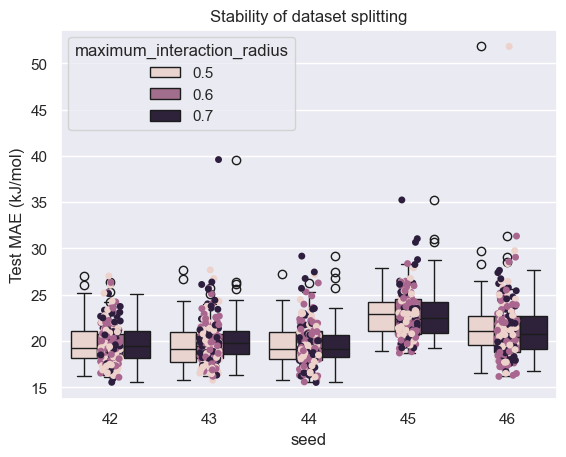

In [53]:
ax = sns.boxplot(
    data=exp_results_df,
    x="seed",
    y="test/per_system_energy/mae",
    hue="maximum_interaction_radius",
)
sns.stripplot(
    data=exp_results_df, 
    x="seed", 
    y="test/per_system_energy/mae",
    hue="maximum_interaction_radius",
    legend=False,
)
ax.set_ylabel("Test MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
plt.show()

### Impact of number_of_per_atom_features

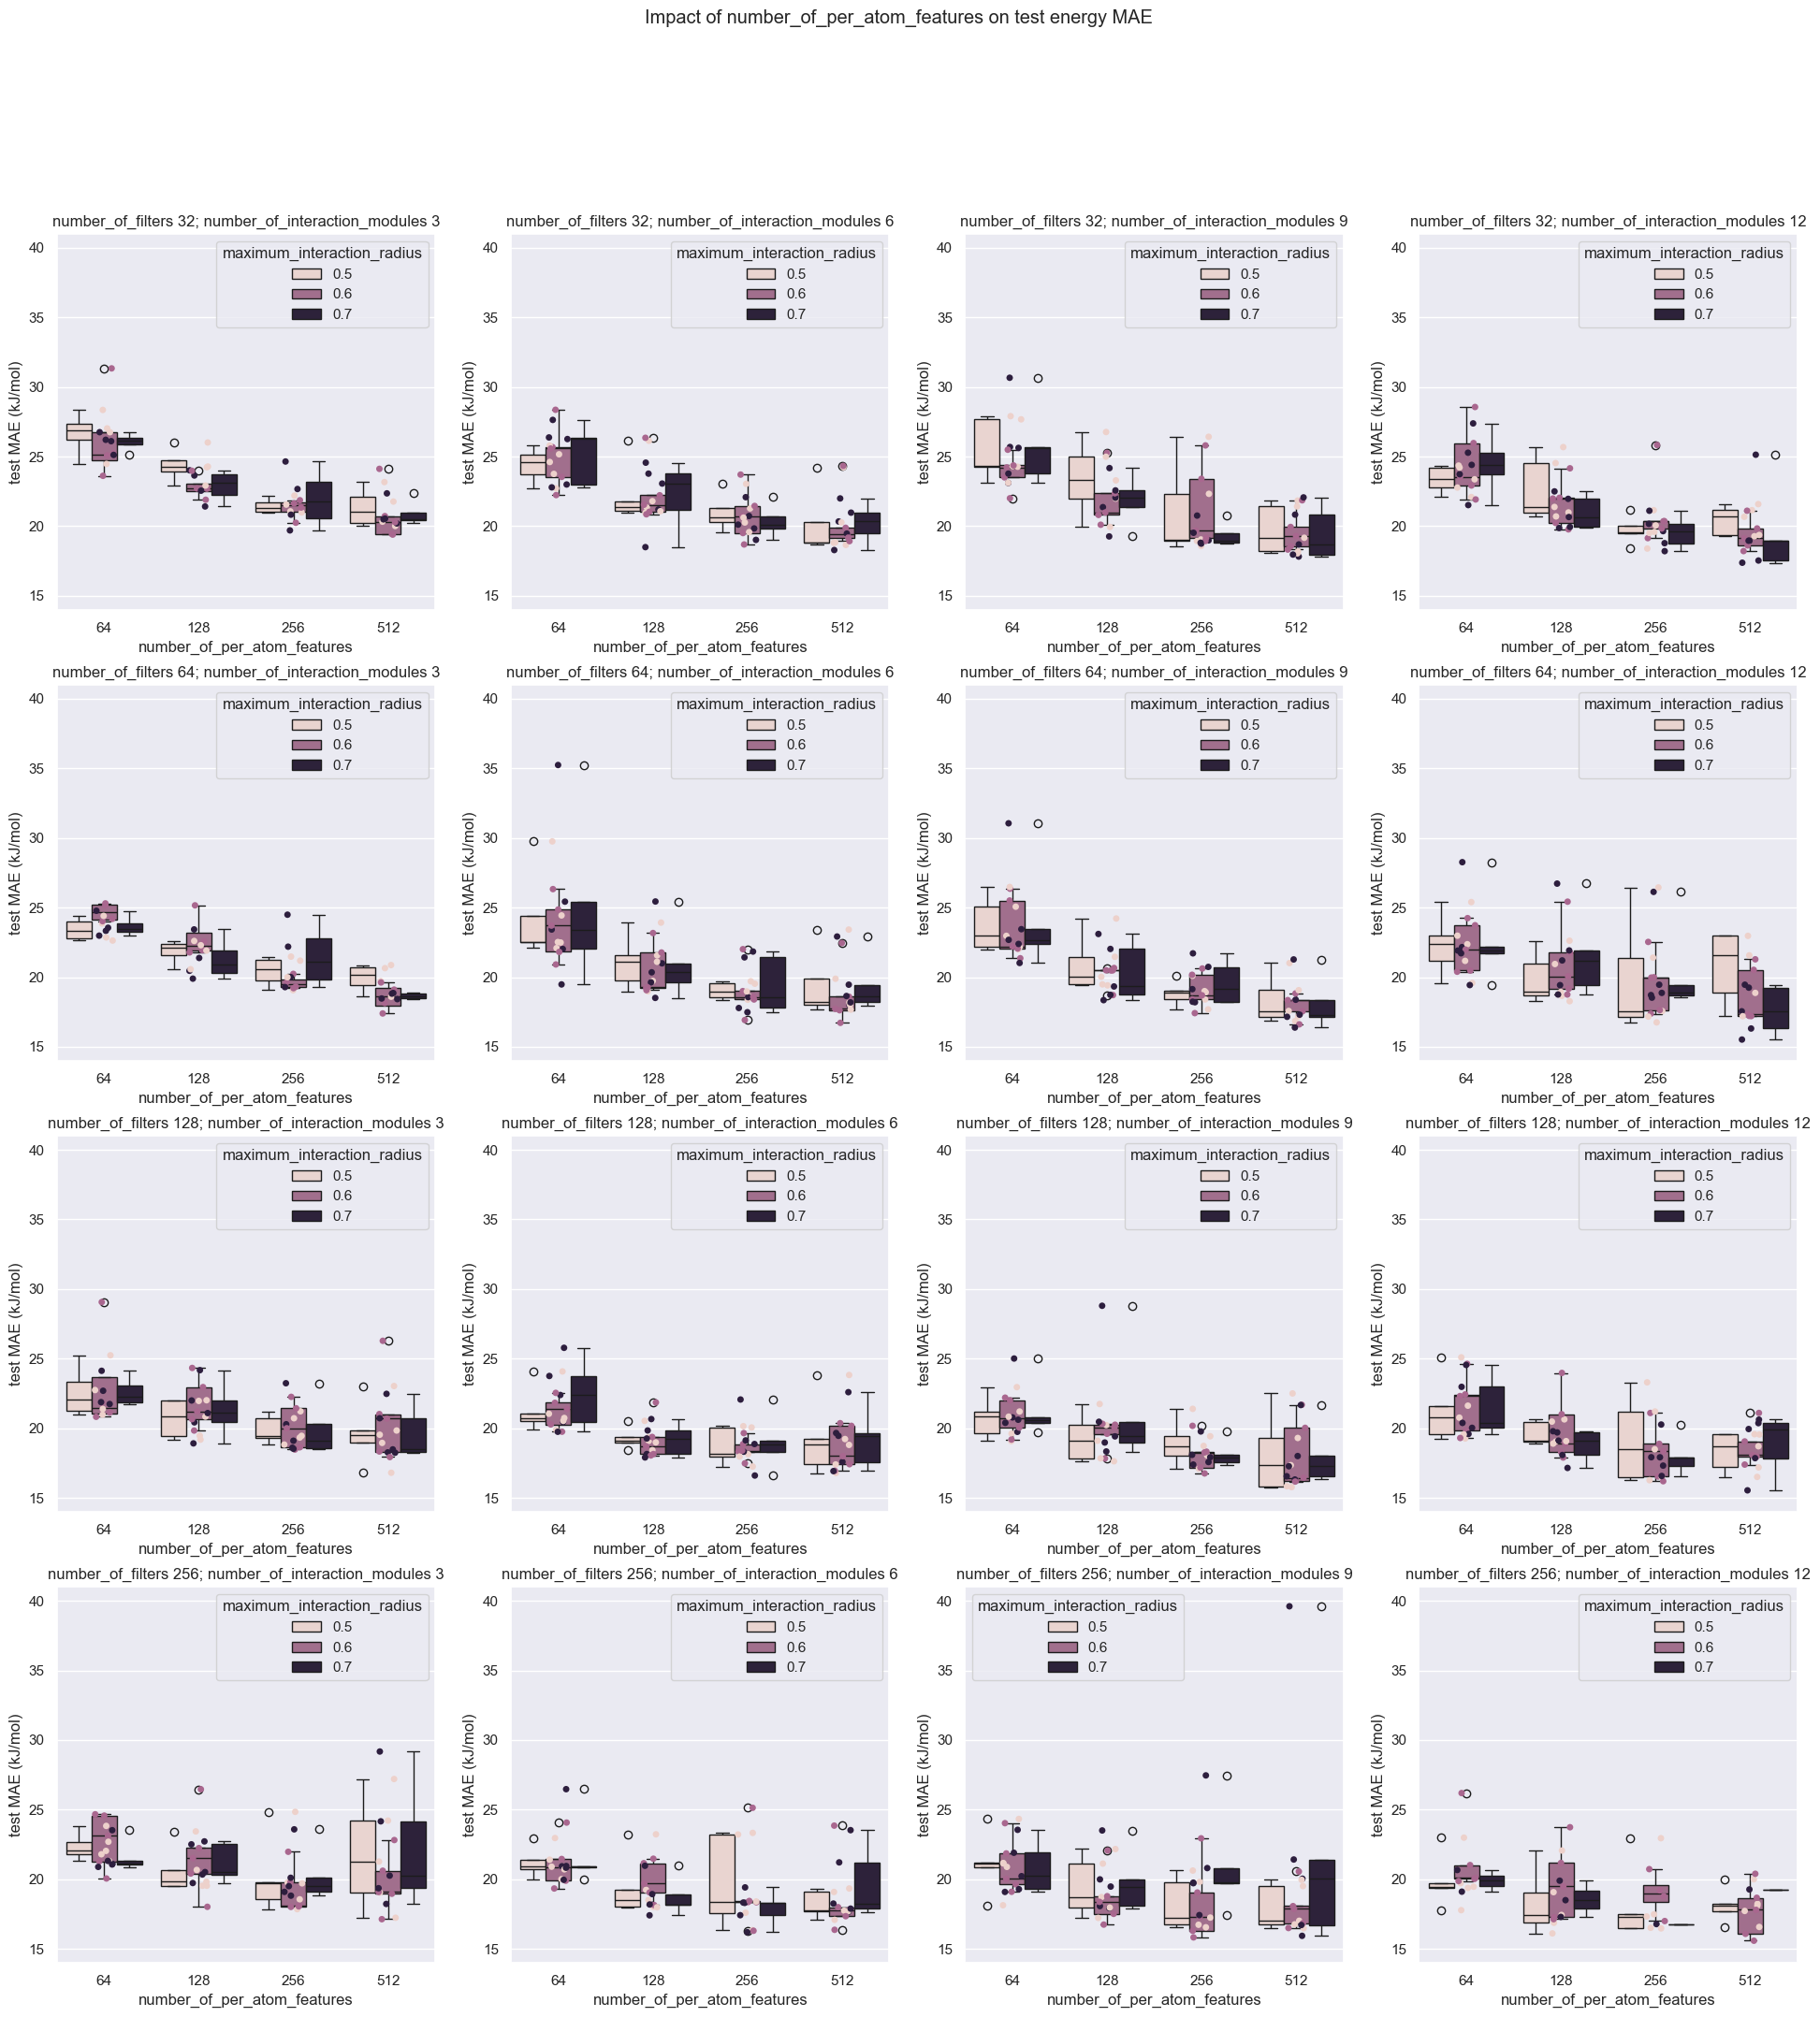

In [54]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
fig.suptitle("Impact of number_of_per_atom_features on test energy MAE")

exp_results_no_charge_emb_df = exp_results_df[(exp_results_df["total_charge_embedding"] == False)]
for i, number_of_filters in enumerate([32, 64, 128, 256]):
    for j, number_of_interaction_modules in enumerate([3, 6, 9, 12]):
        plot_results = exp_results_no_charge_emb_df[
            (exp_results_no_charge_emb_df["number_of_filters"] == number_of_filters) & \
            (exp_results_no_charge_emb_df["number_of_interaction_modules"] == number_of_interaction_modules)
        ]
        sns.boxplot(
            ax=axes[i, j],
            data=plot_results,
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="maximum_interaction_radius",
        )
        sns.stripplot(
            ax=axes[i, j],
            data=plot_results, 
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="maximum_interaction_radius",
            legend=False,
        )
        axes[i, j].set_ylim(14, 41)
        axes[i, j].set_ylabel("test MAE (kJ/mol)")
        axes[i, j].set_title(f"number_of_filters {number_of_filters}; number_of_interaction_modules {number_of_interaction_modules}")

# fig.tight_layout()

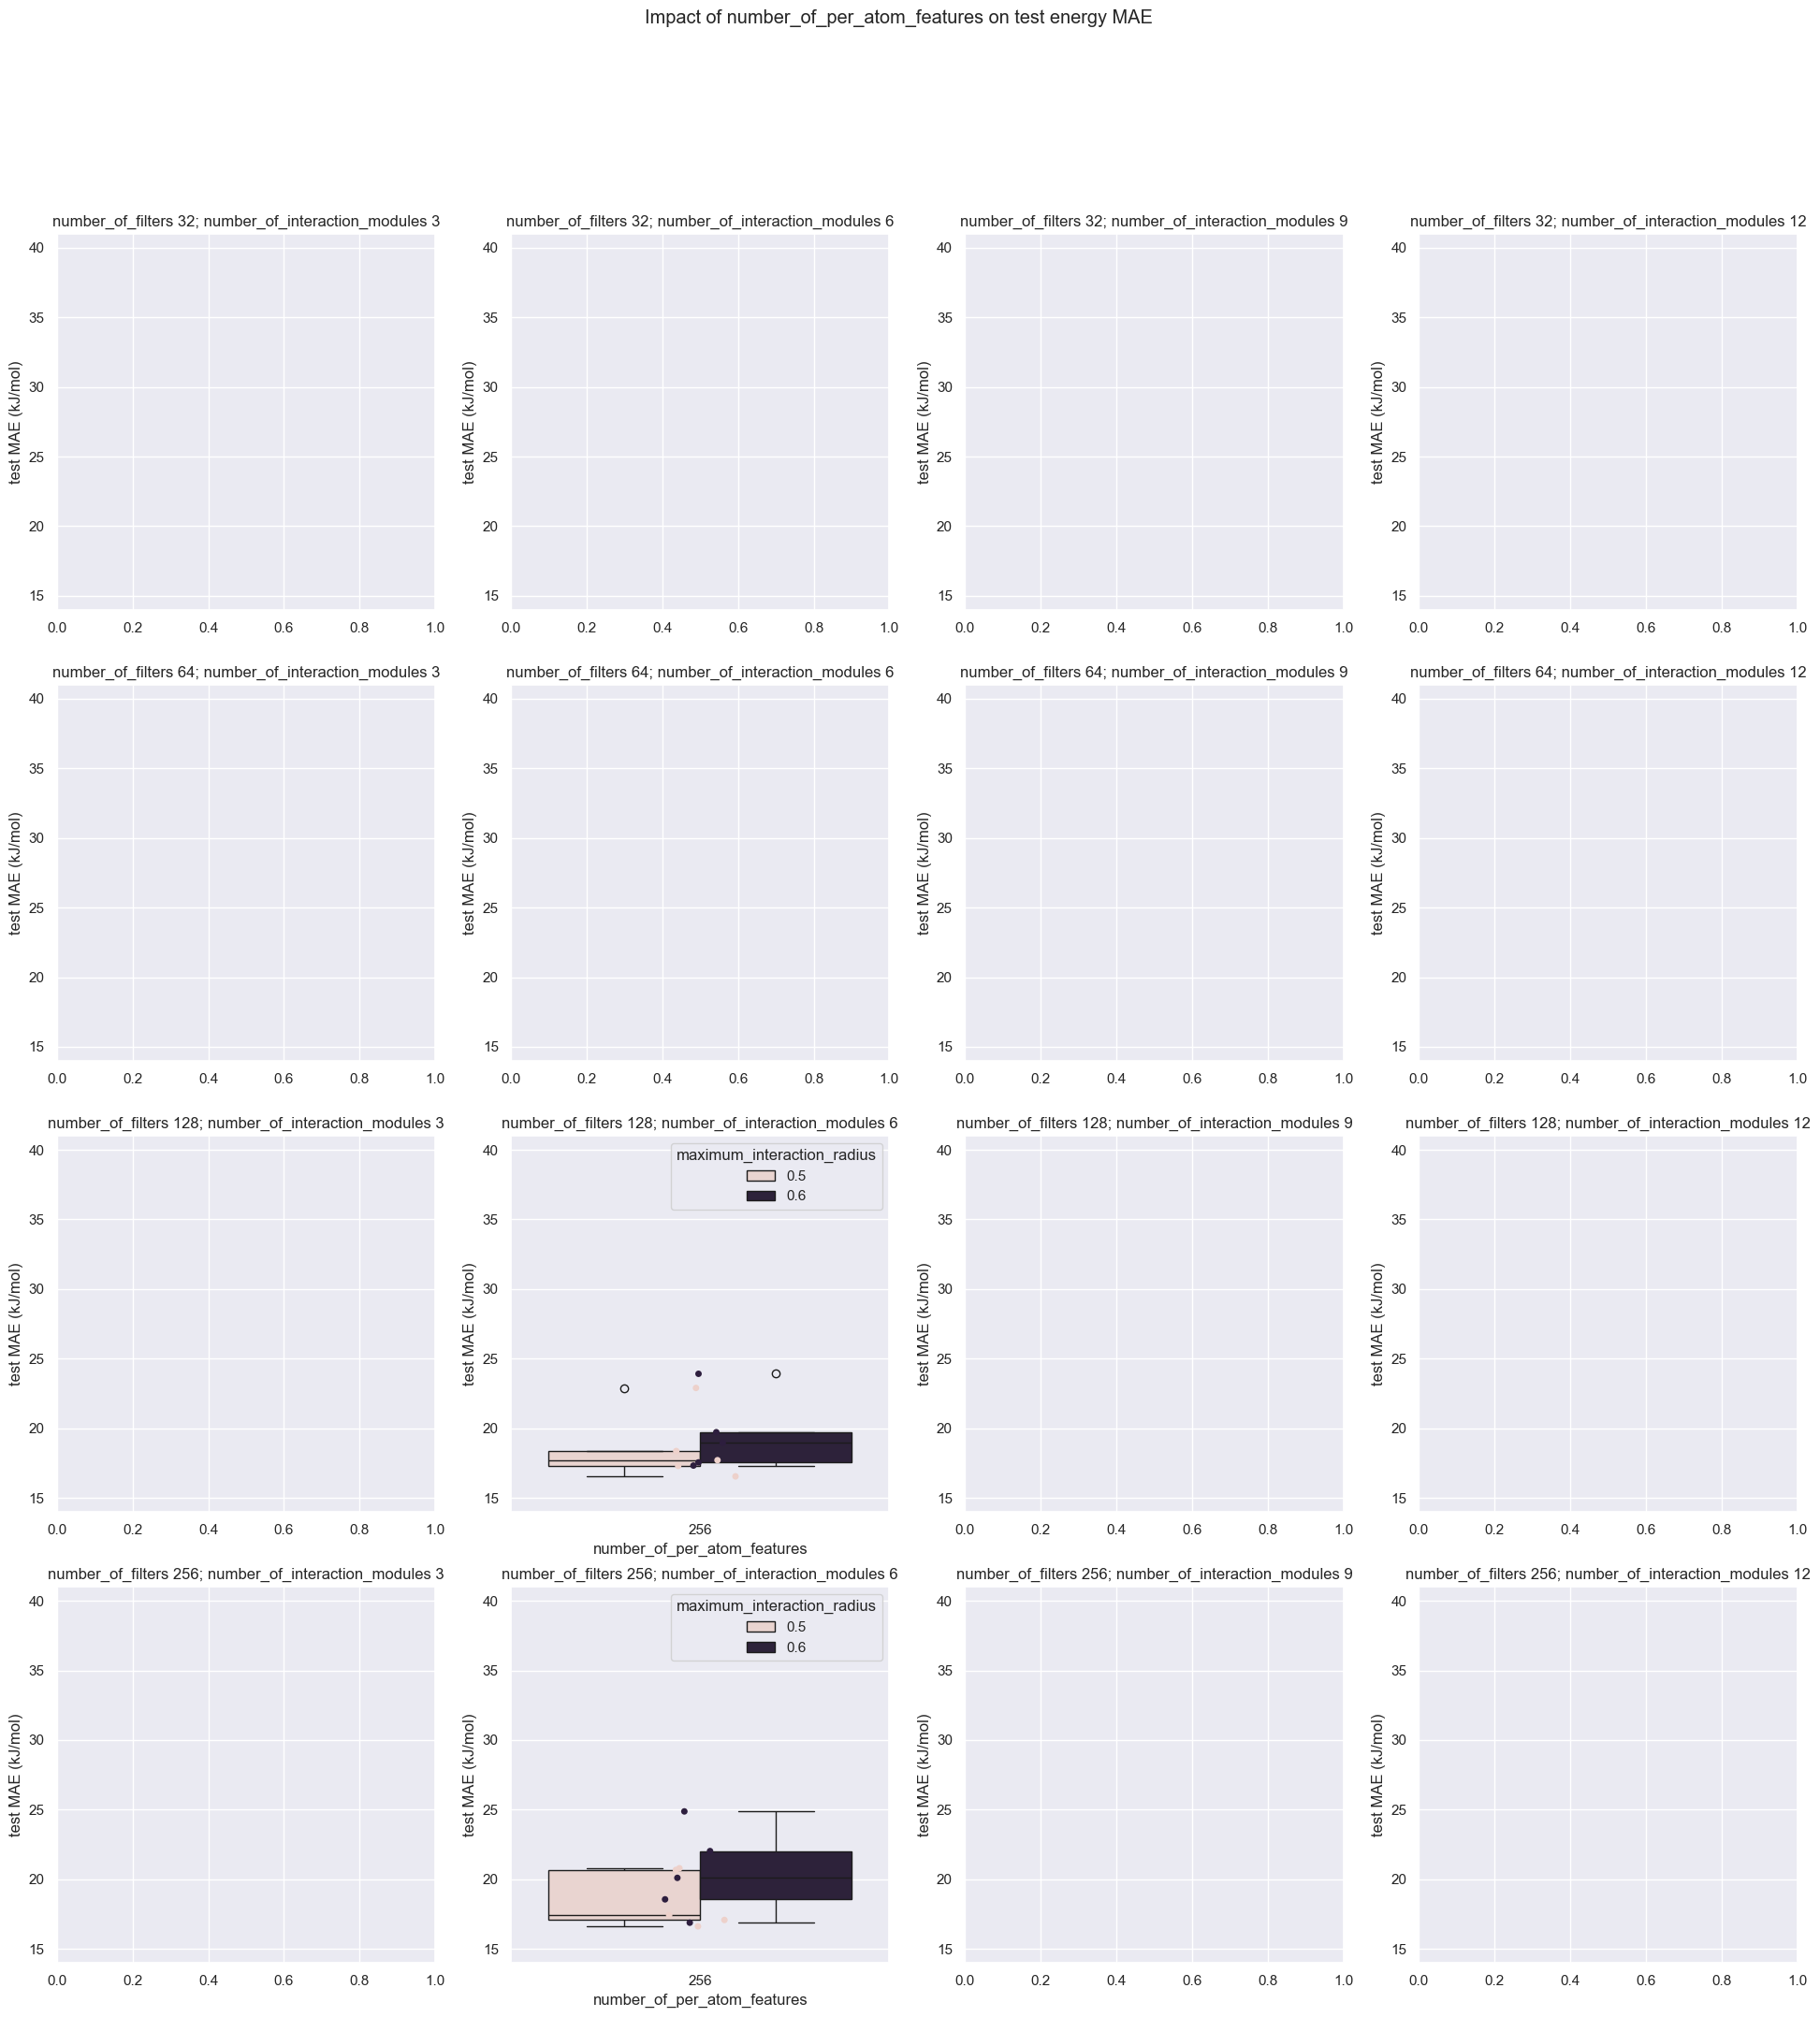

In [55]:
exp_results_charge_emb_df = exp_results_df[(exp_results_df["total_charge_embedding"] == True)]

fig, axes = plt.subplots(4, 4, figsize=(24, 24))
fig.suptitle("Impact of number_of_per_atom_features on test energy MAE")

exp_results_charge_emb_df = exp_results_df[(exp_results_df["total_charge_embedding"] == True)]
for i, number_of_filters in enumerate([32, 64, 128, 256]):
    for j, number_of_interaction_modules in enumerate([3, 6, 9, 12]):
        plot_results = exp_results_charge_emb_df[
            (exp_results_charge_emb_df["number_of_filters"] == number_of_filters) & \
            (exp_results_charge_emb_df["number_of_interaction_modules"] == number_of_interaction_modules)
        ]
        sns.boxplot(
            ax=axes[i, j],
            data=plot_results,
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="maximum_interaction_radius",
        )
        sns.stripplot(
            ax=axes[i, j],
            data=plot_results, 
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="maximum_interaction_radius",
            legend=False,
        )
        axes[i, j].set_ylim(14, 41)
        axes[i, j].set_ylabel("test MAE (kJ/mol)")
        axes[i, j].set_title(f"number_of_filters {number_of_filters}; number_of_interaction_modules {number_of_interaction_modules}")

# fig.tight_layout()

In [56]:
exp_results_df = exp_results_df[(exp_results_df["maximum_interaction_radius"] == 0.5)]

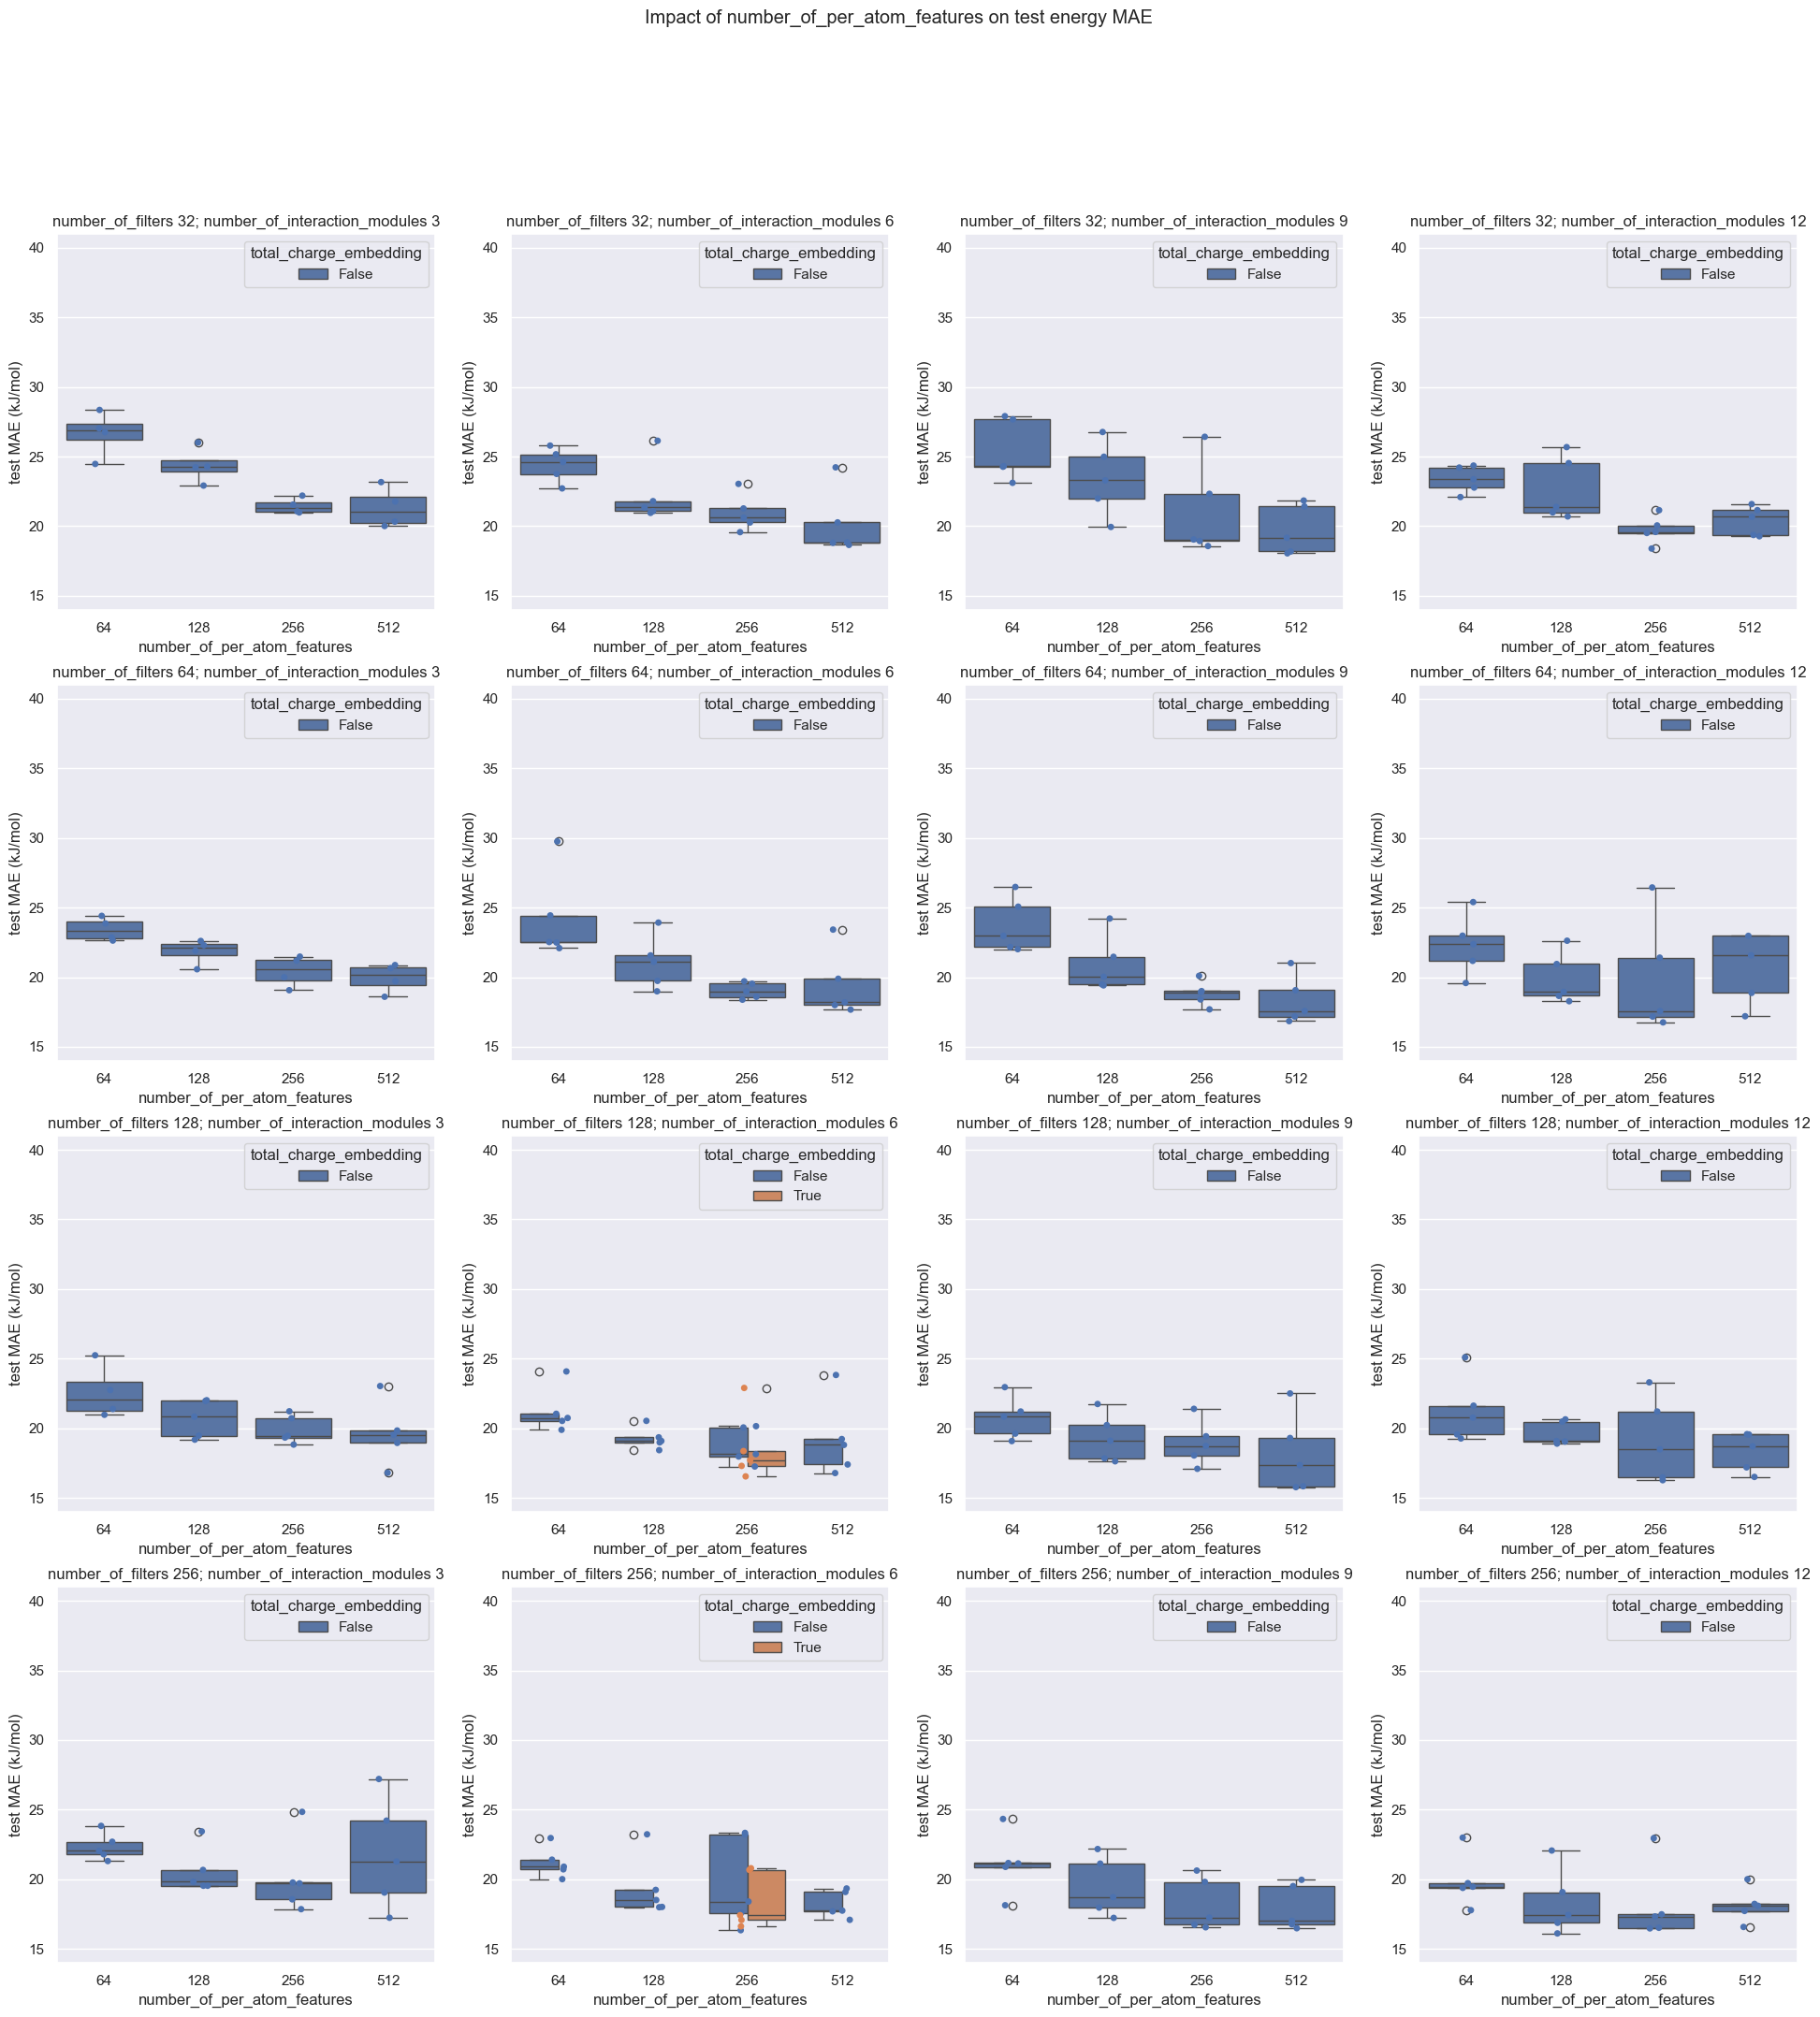

In [57]:
fig, axes = plt.subplots(4, 4, figsize=(24, 24))
fig.suptitle("Impact of number_of_per_atom_features on test energy MAE")

for i, number_of_filters in enumerate([32, 64, 128, 256]):
    for j, number_of_interaction_modules in enumerate([3, 6, 9, 12]):
        plot_results = exp_results_df[
            (exp_results_df["number_of_filters"] == number_of_filters) & \
            (exp_results_df["number_of_interaction_modules"] == number_of_interaction_modules)
        ]
        sns.boxplot(
            ax=axes[i, j],
            data=plot_results,
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="total_charge_embedding",
        )
        sns.stripplot(
            ax=axes[i, j],
            data=plot_results, 
            x="number_of_per_atom_features",
            y="test/per_system_energy/mae",
            hue="total_charge_embedding",
            legend=False,
        )
        axes[i, j].set_ylim(14, 41)
        axes[i, j].set_ylabel("test MAE (kJ/mol)")
        axes[i, j].set_title(f"number_of_filters {number_of_filters}; number_of_interaction_modules {number_of_interaction_modules}")

# fig.tight_layout()

In [48]:
exp_results_df = exp_results_df[(exp_results_df["number_of_per_atom_features"] == 256)]

### Impact of number_of_filters v.s. number_of_interaction_modules

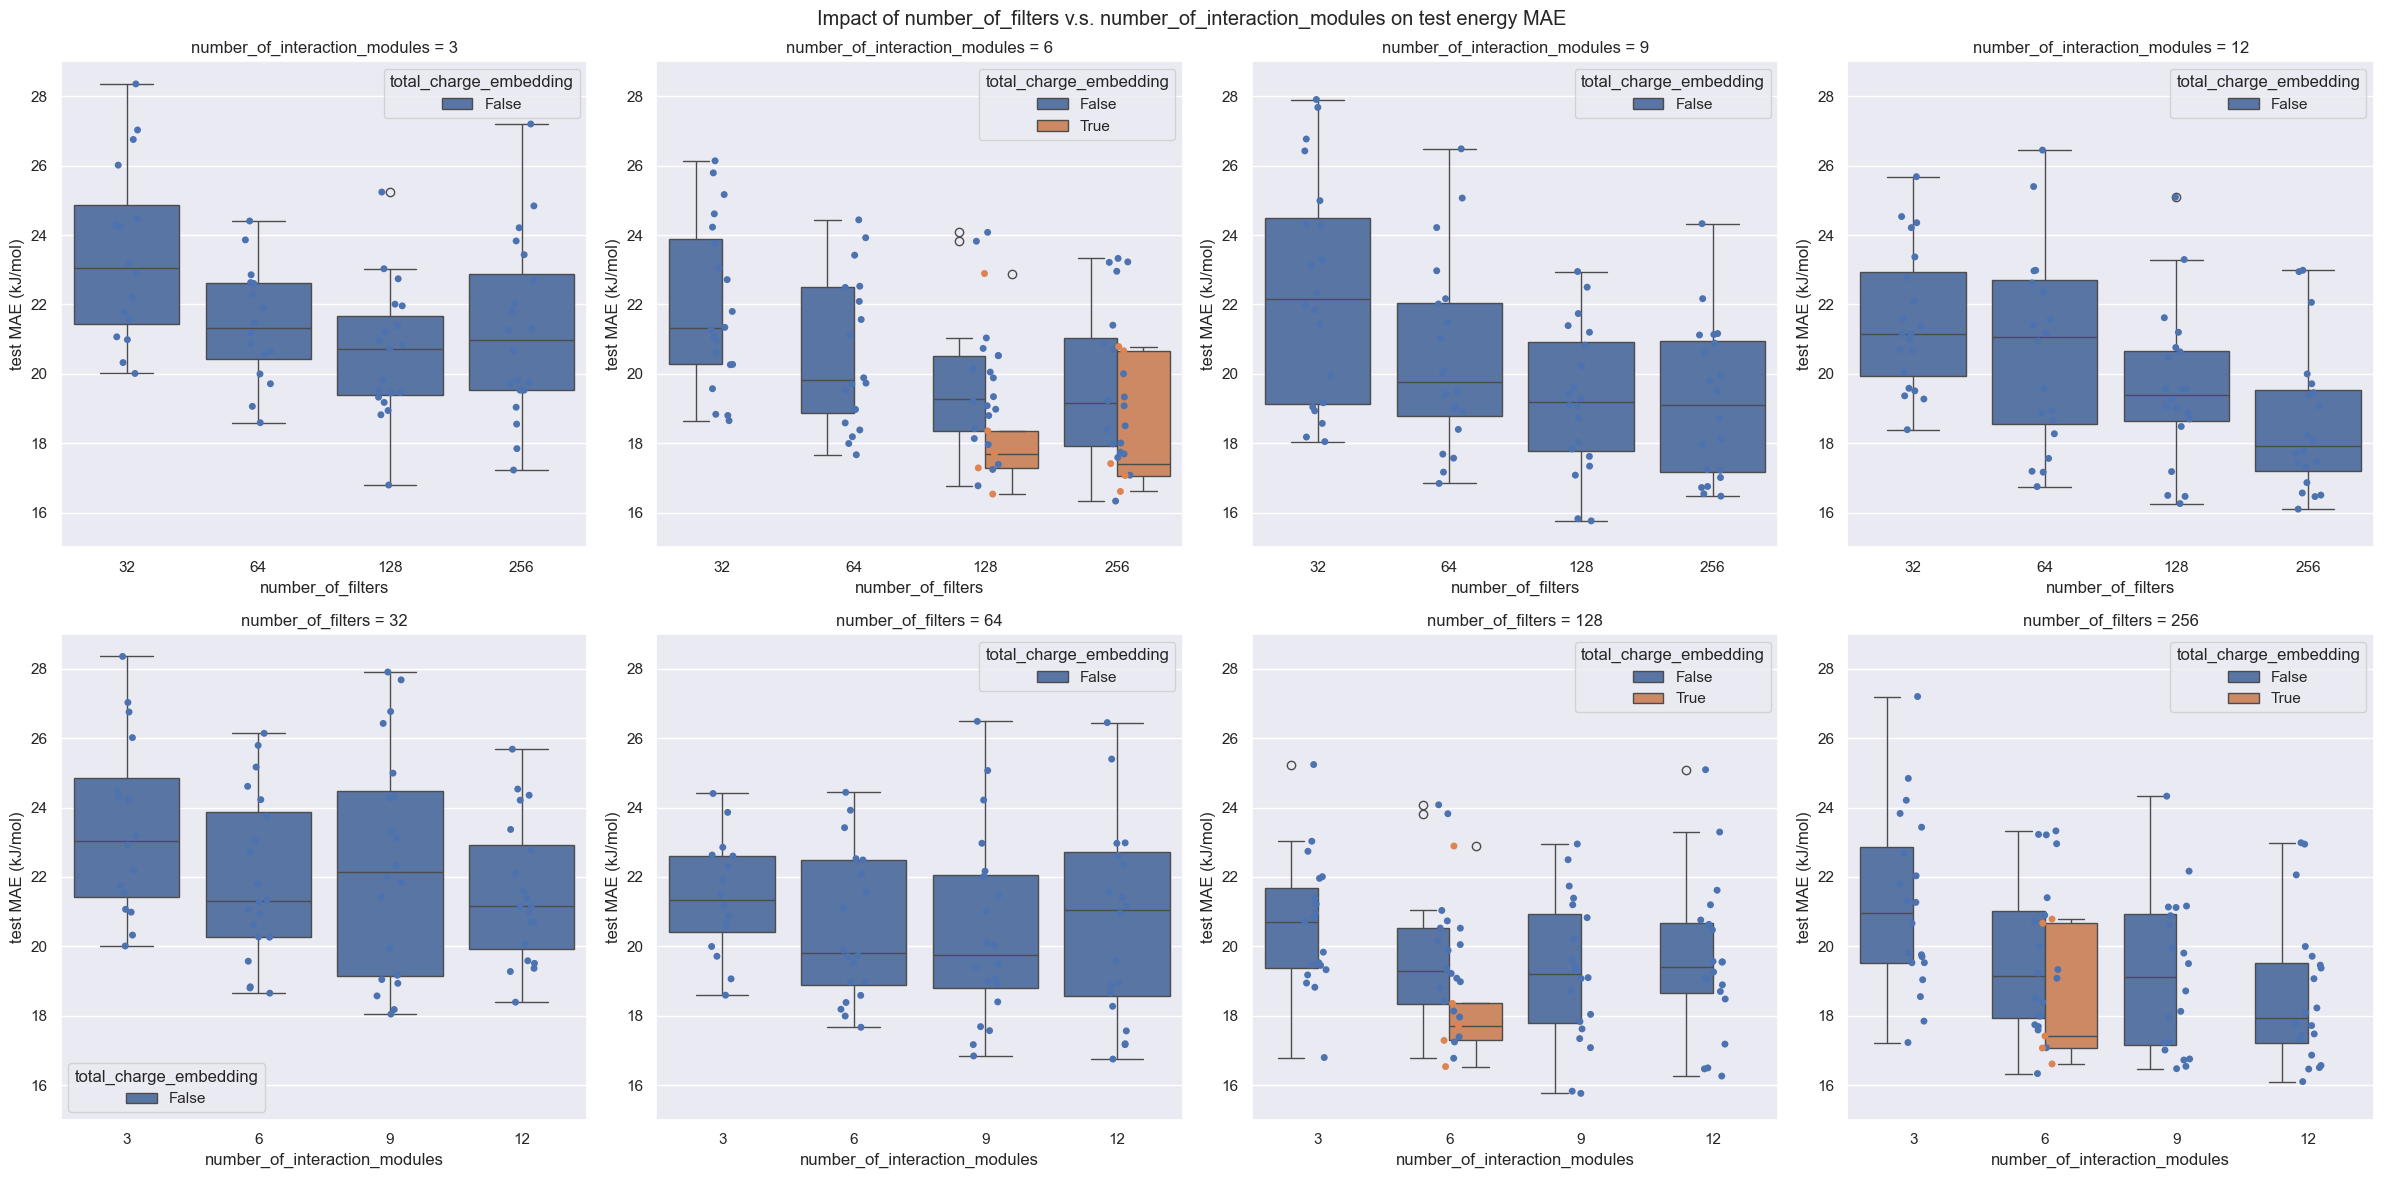

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle("Impact of number_of_filters v.s. number_of_interaction_modules on test energy MAE")

for i, number_of_interaction_modules in enumerate([3, 6, 9, 12]):
    sns.boxplot(
        ax=axes[0, i],
        data=exp_results_df[exp_results_df["number_of_interaction_modules"] == number_of_interaction_modules],
        x="number_of_filters",
        y="test/per_system_energy/mae",
        hue="total_charge_embedding",
    )
    sns.stripplot(
        ax=axes[0, i],
        data=exp_results_df[exp_results_df["number_of_interaction_modules"] == number_of_interaction_modules],
        x="number_of_filters",
        y="test/per_system_energy/mae",
        hue="total_charge_embedding",
        legend=False,
    )
    axes[0, i].set_ylim(15, 29)
    axes[0, i].set_ylabel("test MAE (kJ/mol)")
    axes[0, i].set_title(f"number_of_interaction_modules = {number_of_interaction_modules}")

for i, number_of_filters in enumerate([32, 64, 128, 256]):
    sns.boxplot(
        ax=axes[1, i],
        data=exp_results_df[exp_results_df["number_of_filters"] == number_of_filters],
        x="number_of_interaction_modules",
        y="test/per_system_energy/mae",
        hue="total_charge_embedding",
    )
    sns.stripplot(
        ax=axes[1, i],
        data=exp_results_df[exp_results_df["number_of_filters"] == number_of_filters],
        x="number_of_interaction_modules",
        y="test/per_system_energy/mae",
        hue="total_charge_embedding",
        legend=False,
    )
    axes[1, i].set_ylim(15, 29)
    axes[1, i].set_ylabel("test MAE (kJ/mol)")
    axes[1, i].set_title(f"number_of_filters = {number_of_filters}")

fig.tight_layout()

## Heat map

In [58]:
exp_results_df['test/per_system_energy/mae'] = pd.to_numeric(
    exp_results_df['test/per_system_energy/mae'], errors='coerce'
)

heatmap_df = exp_results_df[exp_results_df["total_charge_embedding"] == False]

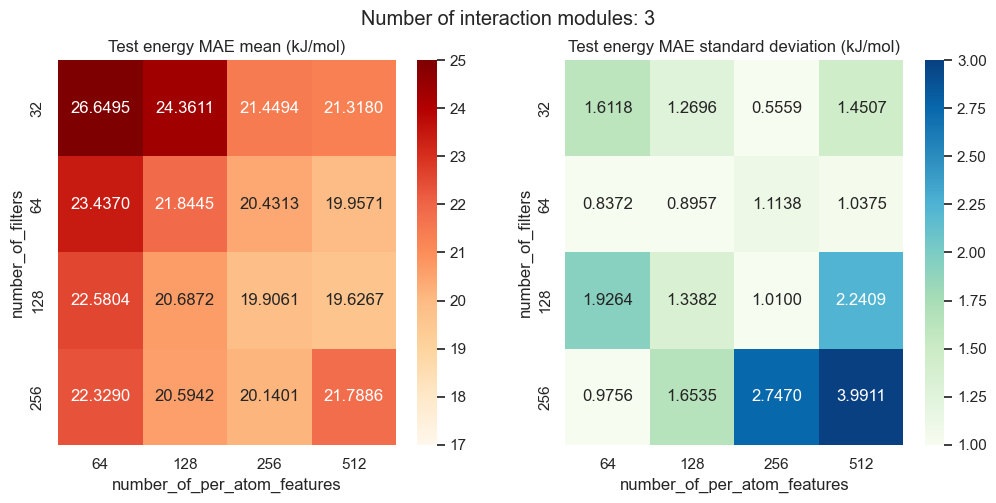

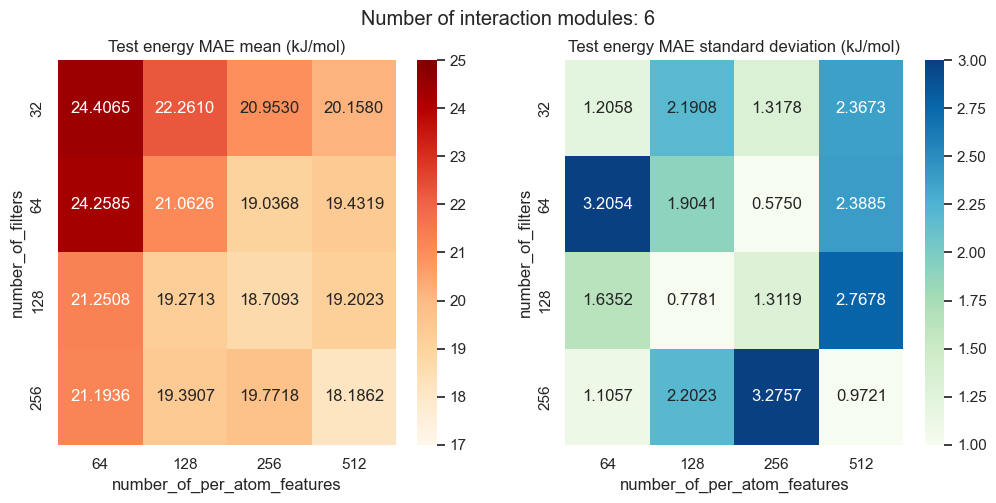

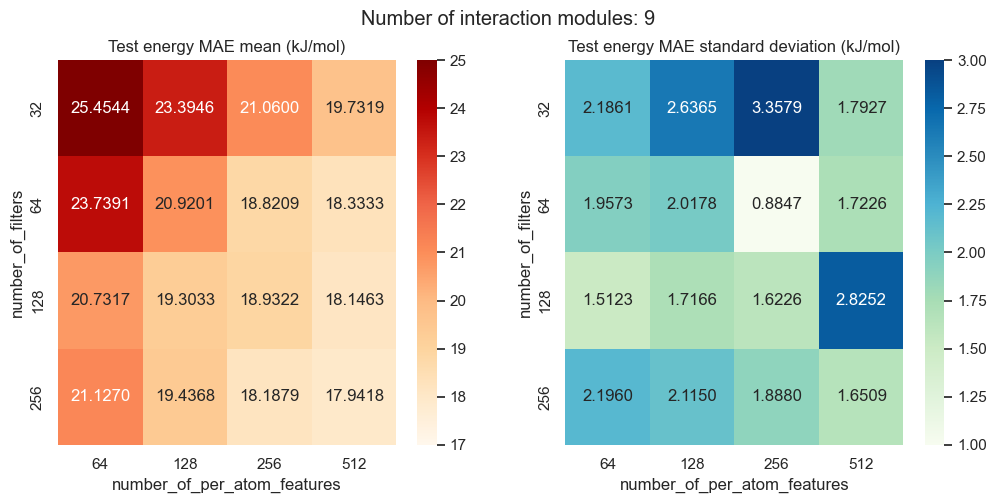

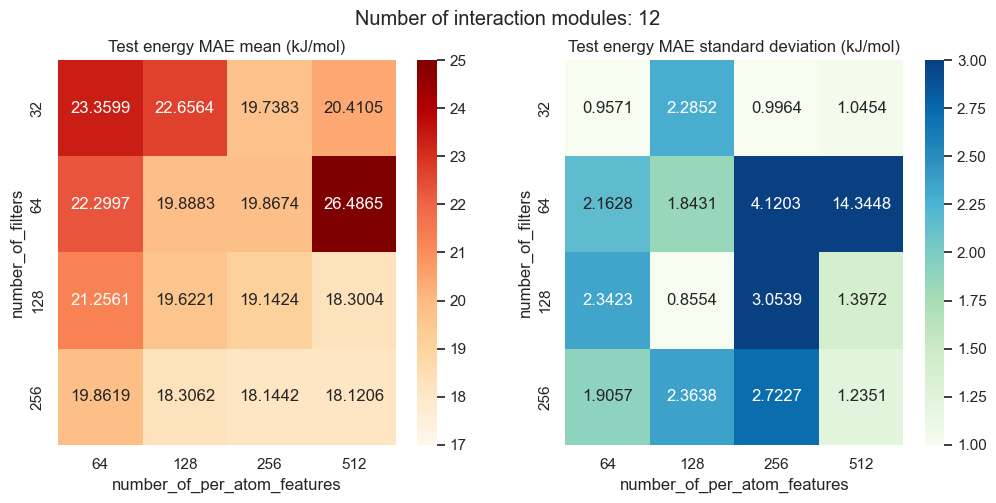

In [60]:
for i in [3, 6, 9, 12]:
    mean_heatmap_df = heatmap_df[heatmap_df["number_of_interaction_modules"] == i][["number_of_per_atom_features", "number_of_filters", "test/per_system_energy/mae"]].groupby(["number_of_filters", "number_of_per_atom_features"]).agg("mean").reset_index()
    std_heatmap_df = heatmap_df[heatmap_df["number_of_interaction_modules"] == i][["number_of_per_atom_features", "number_of_filters", "test/per_system_energy/mae"]].groupby(["number_of_filters", "number_of_per_atom_features"]).agg("std").reset_index()
    mean_heatmap_df = mean_heatmap_df.pivot(
        index="number_of_filters",
        columns="number_of_per_atom_features",
        values="test/per_system_energy/mae",
    )
    std_heatmap_df = std_heatmap_df.pivot(
        index="number_of_filters",
        columns="number_of_per_atom_features",
        values="test/per_system_energy/mae",
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Number of interaction modules: {i}")
    sns.heatmap(
        ax=axes[0],
        data=mean_heatmap_df,
        annot=True,
        fmt=".4f",
        cmap='OrRd',
        vmin=17,
        vmax=25,
    )
    axes[0].set_title("Test energy MAE mean (kJ/mol)")
    sns.heatmap(
        ax=axes[1],
        data=std_heatmap_df,
        annot=True,
        fmt=".4f",
        cmap='GnBu',
        vmin=1,
        vmax=3,
    )
    axes[1].set_title("Test energy MAE standard deviation (kJ/mol)")